In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

location = 'W'
weather = 'W'
n = 10
# # Read Excel files on ASUS laptop

# Read Excel files on PC office
df_data = pd.read_excel(f"/home/user/PHDLund/PythonProjects_github/PyTorch_tutorial/Multi-mission altimetry/Input_to_ML/{location}_alt_{weather}_env_{n}days.xlsx")   # columns: DateTime, Predicted_WSE, Sensor

input_point_features = np.column_stack([
    df_data['Predicted_WSE'].values,
    df_data['DOY_sin'].values,
    df_data['DOY_cos'].values,
    df_data['Sensor_Code'].values
])

input_T = np.column_stack([
    np.array([ast.literal_eval(s) for s in df_data['Temp_series'].values])
])

input_P = np.column_stack([
    np.array([ast.literal_eval(s) for s in df_data['Prec_series'].values])
])
input_Ev = np.column_stack([
    np.array([ast.literal_eval(s) for s in df_data['Evap_series'].values])
])
target = np.column_stack([
    df_data['In_Situ_WSE'].values
])

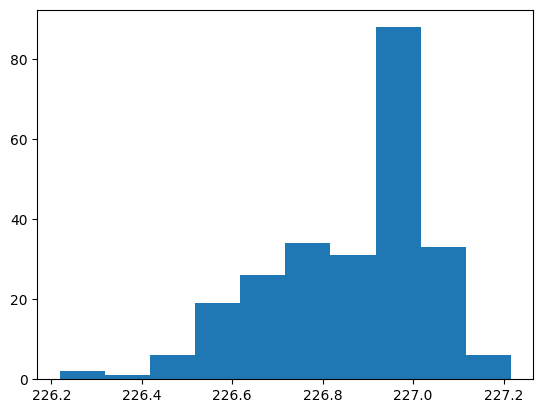

In [2]:
from scipy import stats

def r_squared(y, y_hat):
    '''  R^2 , y is actual'''
    slope_, intercept_, r_value, p_value, std_err = stats.linregress(y, y_hat)
    return r_value**2 * 100

def mape(y, y_hat):
    ''' Mean Absolute Percentage Error '''
    return 100 * np.mean(np.abs((y - y_hat) / y))

plt.hist(target, 10);

########################################
RMSE (RF): 0.18911464412788626
MAPE (RF): 0.06452500791441929
R2   (RF): 46.34543981856354
PCC   (RF): 68.07748513169648


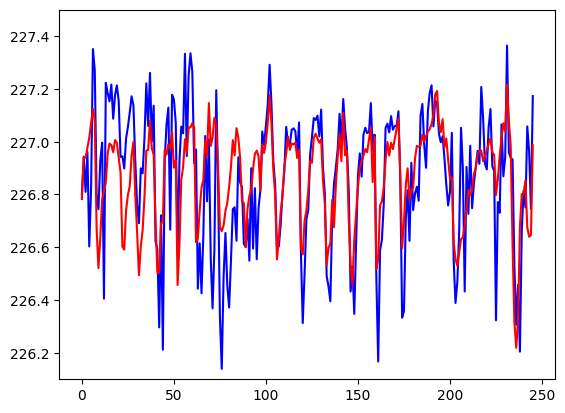

In [3]:
plt.plot(input_point_features[:, 0], 'b') #blue is altimetry
plt.plot(target[:, 0], 'r') # red is in-situ
plt.ylim([226.1, 227.5]) # W
# plt.ylim([175.1, 177.1]) # M

rmse_value = np.sqrt(np.mean((input_point_features[:, 0] - target[:, 0])**2))
MAPE_value = mape(target[:, 0], input_point_features[:, 0])
r2_value = r_squared(target[:, 0], input_point_features[:, 0])
pcc_value = np.corrcoef(target[:, 0], input_point_features[:, 0])[0, 1] * 100  # Pearson Correlation Coefficient
print("########################################")
print("RMSE (RF):", rmse_value)
print("MAPE (RF):", MAPE_value)
print("R2   (RF):", r2_value)
print("PCC   (RF):", pcc_value)

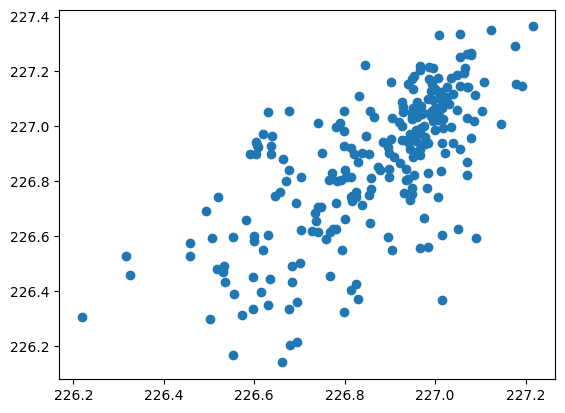

In [4]:
plt.scatter(target[:, 0], input_point_features[:, 0]) #x is in-situ

data_total, (246, 1)
min, 0.0
max, 1.0
mean, 0.6479436253988404
std, 0.17759663304563086


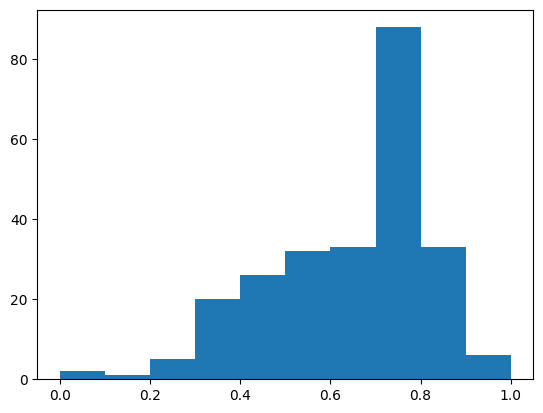

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# We must Normalize across all timesteps and samples — not per timestep

def log_scale_transform_timeseries(X):
    
    shift_value_X = np.abs(np.min(X)) + 1  # Shift X to ensure positive values
    
    X_shifted = X + shift_value_X
    
    X_log = np.log(X_shifted)

    transformerX = RobustScaler().fit(X_log)
    X_trans = transformerX.transform(X_log)
    min_max_scalerX = MinMaxScaler().fit(X_trans)
    X_trans2 = min_max_scalerX.transform(X_trans)

    return X_trans2, transformerX, min_max_scalerX, shift_value_X

input_T_flat = input_T.reshape(-1, 1) # stacks each row of input_T in a single column
input_T_flat_rescaled, transformerT, min_max_scalerT, shift_value_T  = log_scale_transform_timeseries(input_T_flat)
input_T_rescaled = input_T_flat_rescaled.reshape(-1, input_T.shape[1])

input_P_flat = input_P.reshape(-1, 1) # stacks each row of input_T in a single column
input_P_flat_rescaled, transformerP, min_max_scalerP, shift_value_P  = log_scale_transform_timeseries(input_P_flat)
input_P_rescaled = input_P_flat_rescaled.reshape(-1, input_P.shape[1])

input_Ev_flat = input_Ev.reshape(-1, 1) # stacks each row of input_T in a single column
input_Ev_flat_rescaled, transformerEv, min_max_scalerEv, shift_value_Ev  = log_scale_transform_timeseries(input_Ev_flat)
input_Ev_rescaled = input_Ev_flat_rescaled.reshape(-1, input_Ev.shape[1])


def log_scale_transform(X, Y):
    
    shift_value_X = np.abs(np.min(X)) + 1  # Shift X to ensure positive values
    shift_value_Y = np.abs(np.min(Y)) + 1  # Shift Y similarly
    
    X_shifted = X + shift_value_X
    Y_shifted = Y + shift_value_Y
    
    X_log = np.log(X_shifted)
    Y_log = np.log(Y_shifted)

    transformerX = RobustScaler().fit(X_log)
    X_trans = transformerX.transform(X_log)
    min_max_scalerX = MinMaxScaler().fit(X_trans)
    X_trans2 = min_max_scalerX.transform(X_trans)

    transformerY = RobustScaler().fit(np.reshape(Y_log,(-1,1)))
    Y_trans = transformerY.transform(np.reshape(Y_log,(-1,1)))
    min_max_scalerY = MinMaxScaler().fit(Y_trans)
    Y_trans2 = min_max_scalerY.transform(Y_trans)

    return X_trans2, Y_trans2, transformerX, transformerY, min_max_scalerX, min_max_scalerY, shift_value_X, shift_value_Y

input_point_rescaled, y_rescaled, transformerPoint, transformerY, min_max_scalerPoint, min_max_scalerY, shift_value_Point, shift_value_Y  = log_scale_transform(input_point_features, target)

# y_rescaled = np.squeeze(y_rescaled)

print('data_total,' , y_rescaled.shape)
print('min,' ,np.min(y_rescaled))
print('max,' ,np.max(y_rescaled))
print('mean,' ,np.mean(y_rescaled))
print('std,' ,np.std(y_rescaled))

plt.hist(y_rescaled, 10);

def y_to_initial_scale(y, min_max_scaler, transformer, shift):
    y = min_max_scaler.inverse_transform(y.reshape(-1, 1))
    y = transformer.inverse_transform(y)
    return np.exp(y) - shift - 1

In [6]:
import torch
import torch.nn as nn

class CustomLSTMstack(nn.Module):

    def __init__(self, input_size, hidden_sizes, proj_size = None, dropout_rate = 0):

        # input_size is the number of input features
        # hidden_sizes must be a list like [6, 3, 2]
        # proj_size only is considered for the last layer 
        # dropout_rate only is not considered for the last layer

        super().__init__()

        self.layers = nn.ModuleList()
        self.hidden_sizes = hidden_sizes

        for i in range(len(hidden_sizes)):
            in_size = input_size if i==0 else hidden_sizes[i-1]
            hidden_size = hidden_sizes[i]
            is_last = ( i == len(hidden_sizes) - 1) # True or False

            lstm = nn.LSTM(
                
                input_size = in_size,
                hidden_size = hidden_size,
                num_layers = 1,
                proj_size = proj_size if is_last and proj_size is not None else 0,
                dropout = dropout_rate if not is_last and len(hidden_sizes) > 1 else 0,
                bias = True,
                bidirectional=False,
                batch_first = True,

            )

            self.layers.append(lstm)

    def forward(self, x):

        for i, lstm in enumerate(self.layers):
            
            x, (hn, cn) = lstm(x) # so in the stacked format, the outputs are passed to the next lstm not the hidden stated

        return hn[-1] #shape: (samples, proj_size)

class LSTMRegressor(nn.Module):

    def __init__(self, seq_input_size, lstm_hidden_sizes, proj_size,
                 point_features_shape, mlp_layer_sizes, target_size, dropout_rate = 0):
        super().__init__()

        # seq_input_size is the number of input features for LSTM
        # lstm_hidden_sizes must be a list like [6, 3, 2] for LSTM
        # proj_size only is considered for the last layer for LSTM
        # dropout_rate only is not considered for the last layer for LSTM and also works for MLP
        # point_features_shape is a number of point-based features
        # mlp_layer_sizes is a list like [8, 10, 12]
        # target_size is a simple number like 1

        self.lstm_stack = CustomLSTMstack(

            input_size = seq_input_size,
            hidden_sizes = lstm_hidden_sizes,
            proj_size = proj_size,
            dropout_rate = dropout_rate

        )

        lstm_output_size = proj_size if proj_size is not None else lstm_hidden_sizes[-1]
        mlp_input_size = lstm_output_size + point_features_shape

        mlp_layers = []
        mlp_layer_sizes = [mlp_input_size] + mlp_layer_sizes

        for i in range(len(mlp_layer_sizes) - 1):
            mlp_layers.append(nn.Linear(mlp_layer_sizes[i], mlp_layer_sizes[i+1]))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout_rate))

        mlp_layers.append(nn.Linear(mlp_layer_sizes[-1], target_size))

        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self,x_seq, x_point):
        
        lstm_lasthidden = self.lstm_stack(x_seq)
        combined = torch.cat([lstm_lasthidden, x_point], dim = 1)

        return self.mlp(combined)

In [7]:
import pandas as pd
import os

csv_file = f"/home/user/PHDLund/PythonProjects_github/PyTorch_tutorial/Multi-mission altimetry/Input_to_ML/{location}_alt_{weather}_env_{n}days_hyperparam_results.csv"

def log_results(params, fold_metrics, file_path=csv_file):
    metrics_names = ['RMSE', 'MAPE', 'R2', 'PCC']
    row = {**params}

    # Add only the mean of each metric
    for metric in metrics_names:
        row[f'{metric}_mean'] = np.mean(fold_metrics[metric])

    df = pd.DataFrame([row])

    if not os.path.exists(file_path):
        df.to_csv(file_path, index=False)
    else:
        df.to_csv(file_path, mode='a', index=False, header=False)


In [8]:
### Finutune model hyperparameters using 5-fold validation on the whole training data

import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim
from itertools import product
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_seq = np.stack([input_P_rescaled, input_Ev_rescaled, input_T_rescaled], axis=2)
x_seq_tensor = torch.tensor(x_seq, dtype = torch.float32).to(device)
x_point_tensor = torch.tensor(input_point_rescaled, dtype = torch.float32).to(device)
y_tensor = torch.tensor(y_rescaled, dtype=torch.float32).to(device)

dataset = TensorDataset(x_seq_tensor, x_point_tensor, y_tensor)

# # Define search space
# param_grid = {
#     'lr': [1e-3],
#     'weight_decay': [1e-5],
#     'epochs': [50],
#     'batch_size': [64],
#     'lstm_hidden_sizes': [[16, 8, 4]],
#     'mlp_layer_sizes': [[32, 16]],
#     'dropout_rate': [0, 0.4],
# }

# Define search space
param_grid = {
    'lr': [1e-3, 5e-1,  1e-4],
    'weight_decay': [0, 1e-5, 1e-6],
    'epochs': [100, 150, 200],
    'batch_size': [64, 32, 16],
    'lstm_hidden_sizes': [[6, 6, 6], [6, 6, 3], [6, 3, 3], [3, 3, 3], [6, 3], [3, 6], [3], [6]],
    'mlp_layer_sizes': [[6, 3], [3, 6], [3, 3], [3], [6]],
    'dropout_rate': [0, 0.1, 0.2],
}

# Generate all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Track best
best_params = None
best_score = float('inf')

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for param_values in param_combinations:
    params = dict(zip(param_names, param_values))
    print(f"\nTrying params: {params}")

    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=params['batch_size'])

        model = LSTMRegressor(
            seq_input_size=x_seq_tensor.shape[-1],
            lstm_hidden_sizes=params['lstm_hidden_sizes'],
            proj_size=None,
            point_features_shape=x_point_tensor.shape[-1],
            mlp_layer_sizes=params['mlp_layer_sizes'],
            target_size=y_tensor.shape[-1],
            dropout_rate=params['dropout_rate']
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

        # Training loop
        for epoch in range(params['epochs']):
            model.train()
            for x_seq_batch, x_point_batch, y_batch in train_loader:
                x_seq_batch = x_seq_batch.to(device)
                x_point_batch = x_point_batch.to(device)
                y_batch = y_batch.to(device)

                preds = model(x_seq_batch, x_point_batch)
                loss = criterion(preds, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        count = 0
        with torch.no_grad():

            fold_metrics = {'RMSE': [], 'MAPE': [], 'R2': [], 'PCC': []}

            for x_seq_batch, x_point_batch, y_batch in val_loader:
                x_seq_batch = x_seq_batch.to(device)
                x_point_batch = x_point_batch.to(device)
                y_batch = y_batch.to(device)

                preds = model(x_seq_batch, x_point_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item() * x_seq_batch.size(0)
                count += x_seq_batch.size(0)

                # Move back to CPU and convert to NumPy
                y_true = y_batch.detach().cpu().numpy()
                y_pred = preds.detach().cpu().numpy()

                # Inverse-transform to real-world scale
                y_true_real = y_to_initial_scale(y_true[:, 0], min_max_scalerY, transformerY, shift_value_Y).flatten()
                y_pred_real = y_to_initial_scale(y_pred[:, 0], min_max_scalerY, transformerY, shift_value_Y).flatten()

                # Metrics
                rmse = np.sqrt(np.mean((y_pred_real - y_true_real) ** 2))
                mape_ = mape(y_true_real, y_pred_real)
                r2 = r_squared(y_true_real, y_pred_real)
                pcc = np.corrcoef(y_true_real, y_pred_real)[0, 1] * 100

                fold_metrics['RMSE'].append(rmse)
                fold_metrics['MAPE'].append(mape_)
                fold_metrics['R2'].append(r2)
                fold_metrics['PCC'].append(pcc)

        avg_val_loss = val_loss / count
        fold_scores.append(avg_val_loss)

    log_results(params, fold_metrics)

    mean_score = np.mean(fold_scores)
    print(f"Average validation MSE: {mean_score:.4f}")


Trying params: {'lr': 0.001, 'weight_decay': 0, 'epochs': 100, 'batch_size': 64, 'lstm_hidden_sizes': [6, 6, 6], 'mlp_layer_sizes': [6, 3], 'dropout_rate': 0}
Average validation MSE: 0.0229

Trying params: {'lr': 0.001, 'weight_decay': 0, 'epochs': 100, 'batch_size': 64, 'lstm_hidden_sizes': [6, 6, 6], 'mlp_layer_sizes': [6, 3], 'dropout_rate': 0.1}
Average validation MSE: 0.0787

Trying params: {'lr': 0.001, 'weight_decay': 0, 'epochs': 100, 'batch_size': 64, 'lstm_hidden_sizes': [6, 6, 6], 'mlp_layer_sizes': [6, 3], 'dropout_rate': 0.2}
Average validation MSE: 0.0204

Trying params: {'lr': 0.001, 'weight_decay': 0, 'epochs': 100, 'batch_size': 64, 'lstm_hidden_sizes': [6, 6, 6], 'mlp_layer_sizes': [3, 6], 'dropout_rate': 0}
Average validation MSE: 0.0544

Trying params: {'lr': 0.001, 'weight_decay': 0, 'epochs': 100, 'batch_size': 64, 'lstm_hidden_sizes': [6, 6, 6], 'mlp_layer_sizes': [3, 6], 'dropout_rate': 0.1}
Average validation MSE: 0.0310

Trying params: {'lr': 0.001, 'weight_d

In [ ]:
x_point_batch.shape

In [ ]:
preds.shape

In [ ]:
y_batch.shape

In [ ]:
# simple regressor


import torch
import torch.nn as nn
import torch.optim as optim

# add train validation test
# add batching with Dataloader
# add early stopping
# model.predict?

class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, proj_size, point_features_shape, num_of_neurons, target_size):

        super().__init__()

        self.lstm = nn.LSTM(

            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            proj_size = proj_size,
            dropout = dropout_rate,
            bias = True,
            bidirectional=False,
            batch_first = True,

        )

        self.mlp = nn.Sequential(

            nn.Linear(in_features = proj_size + point_features_shape, out_features = num_of_neurons, bias = True), # in_features can be the hidden_size of the last layer in LSTM,
            nn.ReLU(), #or nn.Sigmoid() # what about adding dropout here
            nn.Linear(in_features = num_of_neurons, out_features = target_size, bias = True),
            # nn.Sigmoid() # or nn.ReLU() # or nothing
        )

    def forward(self, x_seq, x_point):

        _, (hn, _) = self.lstm(x_seq) #outputs are outputs, (hn, cn)
        lstm_output = hn[-1]
        combined = torch.cat([lstm_output, x_point], dim =1)

        return self.mlp(combined)

x_seq = np.stack([input_P_rescaled, input_Ev_rescaled, input_T_rescaled], axis=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_seq_tensor = torch.tensor(x_seq, dtype = torch.float32).to(device)
x_point_tensor = torch.tensor(input_point_rescaled, dtype = torch.float32).to(device)
y_tensor = torch.tensor(y_rescaled, dtype=torch.float32).to(device)

input_size = x_seq_tensor.shape[-1]
hidden_size = x_seq_tensor.shape[-2] #or any other numbers
num_layers = 2
proj_size = 3
point_features_shape = 4
dropout_rate = 0
num_of_neurons = 32
target_size = y_tensor.shape[-1]
lr = 1e-3
weight_decay = 1e-4 # L2 regularization
epochs = 100

model = LSTMRegressor(input_size, hidden_size, num_layers, dropout_rate, proj_size, point_features_shape, num_of_neurons, target_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

for epoch in range(epochs):

    model.train() # This does not train the model by itself. Instead, it sets an internal flag on the model and its submodules. This flag tells layers like: Dropout, LayerNorm, and ... to behave differently during training than evaluation.


    preds = model(x_seq_tensor, x_point_tensor)
    loss = criterion(preds, y_tensor)

    optimizer.zero_grad() # Clears previous gradients from the last .backward() pass.
    loss.backward() #This computes the gradient of the loss with respect to all model parameters.
    optimizer.step() #This updates the model weights using the gradients.

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# LSTM accepts and input of (sample, timestep, feature) for example (246, 10, 3) which 10 indicates the timseries of length 10, 3 are the number of features *when batch_first=True)

x_seq = np.stack([input_P_rescaled, input_Ev_rescaled, input_T_rescaled], axis=2)


# Then, you have to convert your input to tensor (you cannot pass directly a numpy array ta PyTorch model). tensor is also an array but another format only. Most importantly, tensor has GPU support which numpy does not.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_seq_tensor = torch.tensor(x_seq, dtype = torch.float32).to(device)
x_point_tensor = torch.tensor(input_point_rescaled, dtype = torch.float32).to(device)
y_tensor = torch.tensor(y_rescaled, dtype=torch.float32).to(device)
# 
proj_size = 3
lstm = nn.LSTM(input_size = x_seq_tensor.shape[-1], hidden_size = x_seq_tensor.shape[-2], num_layers=1, bias=True, batch_first=True, dropout=0.0, bidirectional=False, proj_size=proj_size).to(device)

hidden_layer_sizes = 32
mlp = nn.Sequential(
    nn.Linear(proj_size + x_point_tensor.shape[-1], out_features = hidden_layer_sizes),
    nn.ReLU(), #or nn.Sigmoid() 
    nn.Linear(hidden_layer_sizes, out_features = y_tensor.shape[-1])
    # nn.Sigmoid() # or nn.ReLU() # or nothing
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(lstm.parameters()) + list(mlp.parameters()), lr=1e-3) #is it needed to do this : list(lstm.parameters()) + list(mlp.parameters())

epochs = 100
for epoch in range(epochs):
    lstm.train()
    mlp.train()

    output_seq, (hn, cn) = lstm(x_seq_tensor)

    lstm_output = hn[-1]

    combined_inputs = torch.cat([lstm_output, x_point_tensor], dim=1)
    preds = mlp(combined_inputs)

    loss = criterion(preds, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f}")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, LeaveOneOut, cross_val_predict

# --------------------------
# 1) Tune hyperparameters using, say, 5-fold CV
# --------------------------
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}
rf_base = RandomForestRegressor(random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=kfold,
    n_jobs=-1
)

grid_search.fit(np.hstack([input_T_rescaled, input_P_rescaled, input_Ev_rescaled, input_point_rescaled]), y_rescaled)
print("Best hyperparameters:", grid_search.best_params_)

In [ ]:
x_rescaled = np.hstack([input_T_rescaled, input_P_rescaled, input_Ev_rescaled, input_point_rescaled])

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# Suppose these are your best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Create the best RF model with these parameters
rf_best = RandomForestRegressor(**best_params, random_state=42)

# Prepare a KFold cross-validator (same splits you used in GridSearchCV, if desired)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
all_rmse = []
all_mape = []
all_r2 = []

def ytest_to_initial_scale(ytest, min_max_scalerY_turb, transformerY_turb, shift_value_Y):
    ytest_inv1 = min_max_scalerY_turb.inverse_transform(np.reshape(ytest, (-1, 1)))
    ytest_inv2 = transformerY_turb.inverse_transform(ytest_inv1)
    ytest_inv2 = np.exp(ytest_inv2)
    ytest_rescaled = ytest_inv2 - shift_value_Y
    return ytest_rescaled

for train_idx, test_idx in kfold.split(x_rescaled, y_rescaled):
    # Split data
    X_train, X_test = x_rescaled[train_idx], x_rescaled[test_idx]
    y_train, y_test = y_rescaled[train_idx], y_rescaled[test_idx]

    # Train on this fold
    rf_best.fit(X_train, y_train)

    # Predict on the test fold (scaled domain)
    y_preds_initial = rf_best.predict(X_test)
    
    # Inverse-transform the predictions and the test targets
    y_preds_unscaled = ytest_to_initial_scale(
        y_preds_initial, 
        min_max_scalerY, 
        transformerY, 
        shift_value_Y
    )
    
    y_test_unscaled = ytest_to_initial_scale(
        y_test, 
        min_max_scalerY, 
        transformerY, 
        shift_value_Y
    )
    
    # Flatten if needed
    y_preds_unscaled = np.squeeze(y_preds_unscaled)
    y_test_unscaled = np.squeeze(y_test_unscaled)
    
    # Compute metrics for this fold
    rmse_value = np.sqrt(np.mean((y_preds_unscaled - y_test_unscaled)**2))
    mape_value = mape(y_test_unscaled, y_preds_unscaled)
    r2_value = r_squared(y_test_unscaled, y_preds_unscaled)
    
    # Append fold metrics
    all_rmse.append(rmse_value)
    all_mape.append(mape_value)
    all_r2.append(r2_value)

# Now average the metrics across the folds
print("Cross-validation results with best hyperparameters:")
print(f"Avg RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Avg MAPE: {np.mean(all_mape):.4f} ± {np.std(all_mape):.4f}")
print(f"Avg R²:   {np.mean(all_r2):.4f} ± {np.std(all_r2):.4f}")

In [ ]:
best_rf = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'],  
                                max_depth = grid_search.best_params_['max_depth'], 
                                min_samples_leaf = grid_search.best_params_['min_samples_leaf'], 
                                min_samples_split = grid_search.best_params_['min_samples_split'], 
                                random_state=42)

y_preds_initial = cross_val_predict(best_rf, x_rescaled, y_rescaled, cv = LeaveOneOut())

def ytest_to_initial_scale(ytest, min_max_scalerY_turb, transformerY_turb, shift_value_Y):
    ytest_inv1 = min_max_scalerY_turb.inverse_transform(np.reshape(ytest, (-1, 1)))
    ytest_inv2 = transformerY_turb.inverse_transform(ytest_inv1)
    ytest_inv2 = np.exp(ytest_inv2)
    ytest_rescaled = ytest_inv2 - shift_value_Y
    return ytest_rescaled

y_preds_RF = ytest_to_initial_scale(y_preds_initial, min_max_scalerY, transformerY, shift_value_Y)
y_preds_RF = np.squeeze(y_preds_RF)

in_situ_measurements = ytest_to_initial_scale(y_rescaled, min_max_scalerY, transformerY, shift_value_Y)
in_situ_measurements = np.squeeze(in_situ_measurements)

rmse_value = np.sqrt(np.mean((y_preds_RF - in_situ_measurements)**2))
MAPE_value = mape(in_situ_measurements, y_preds_RF)
r2_value = r_squared(in_situ_measurements, y_preds_RF)
pcc_value = np.corrcoef(in_situ_measurements, y_preds_RF)[0, 1] * 100  # Pearson Correlation Coefficient
print("########################################")
print("RMSE (RF):", rmse_value)
print("MAPE (RF):", MAPE_value)
print("R2   (RF):", r2_value)
print("PCC   (RF):", pcc_value)

In [ ]:
plt.plot(input_point_features[:, 0], 'g') #g is altimetry
plt.plot(y_preds_RF, 'b')
plt.plot(in_situ_measurements, 'r')
plt.ylim([226.1, 227.5]) # W
# plt.ylim([175.1, 177.1]) # M

In [ ]:
plt.plot(y_preds_RF)